## Part 2 - Clustering

Importing the required libraries and checking for the python version.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import cv2

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Loading only the training dataset for Part 2 of the coursework

In [2]:
CW_DATASET_PATH = "CW_dataset"

def load_train_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)

    return x_train_all, y_train_all

In [3]:
x_train, y_train = load_train_data()

In [4]:
x_train.shape

(9690, 2304)

In [5]:
y_train.shape

(9690, 1)

### 1) K-means Clustering

Plotted the clusters for the train dataset by using a dimentionality reduction technique called PCA.

In [6]:
def plot_clusters(X, y = None):
    plt.scatter(X[:, 0], X[:, 1],c=y, s=3, alpha=0.7) #s is the size of dots.
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

In [7]:
def plot_figure(title, X, y = None):
    plt.figure(figsize=(8, 4))
    plt.title(title)
    plot_clusters(X, y)
    plt.show()

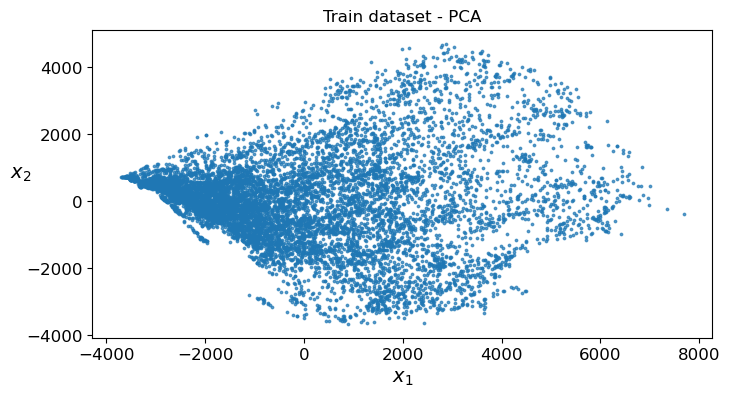

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca1 = pca.fit_transform(x_train, y_train)

plot_figure("Train dataset - PCA", X_pca1)

Preprocessed the train dataset by winsorizing and normalising the data.

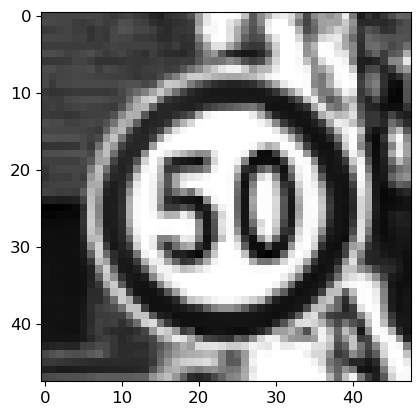

In [9]:
import matplotlib.pyplot as plt

img = x_train.iloc[4391]
img = img.values.reshape((48, 48))

plt.imshow(img, cmap='gray')
plt.show()

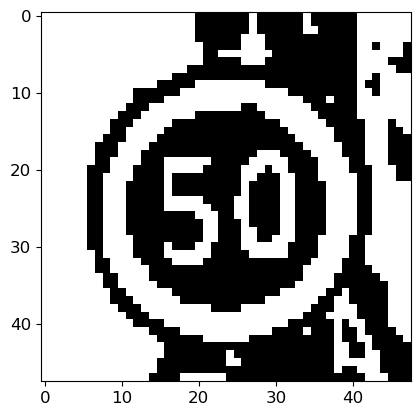

In [10]:
import cv2

ret, thresh1 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh1,cmap='gray')

In [11]:
threshold_value = 120
threshold_img_xtrain = "thresholded_images"

In [12]:
# Create the output folder if it doesn't exist
if not os.path.exists(threshold_img_xtrain):
    os.makedirs(threshold_img_xtrain)

# Loop through the dataset and apply thresholding
for i in range(len(x_train)):
    img = x_train.iloc[i].values.reshape((48, 48))
    ret, thresh1 = cv2.threshold(img, threshold_value, 255, cv2.THRESH_BINARY_INV)
    output_path = os.path.join(threshold_img_xtrain, f"thresholded_{i}.png")
    cv2.imwrite(output_path, thresh1)

In [13]:
thresholded_images = []
for i in range(len(x_train)):
    img_path = os.path.join(threshold_img_xtrain, f"thresholded_{i}.png")
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    thresholded_images.append(img)

x_train = np.array(thresholded_images)

In [14]:
# smoothed_images = []
# for img in x_train:

#     smoothed = cv2.GaussianBlur(img, (5,5), 0)  # You can adjust the kernel size (e.g., (5, 5)) as needed
#     smoothed_images.append(smoothed)
   

# # Convert the list of smoothed images to a numpy array
# x_train = np.asarray(smoothed_images)

In [15]:
# x_train = np.asarray(x_train)

In [16]:
from scipy.stats.mstats import winsorize

# Winsorize the data (adjust percentiles as needed)
winsorized_data = winsorize(x_train, limits=[0.05, 0.05])

def normalise(images):
    preprocessed_images = []
    for image in images: 
        if(len(image.shape) == 3):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)

        adjusted = cv2.convertScaleAbs(image, alpha=0.5, beta = 10)
        enhanced_image = cv2.equalizeHist(adjusted)
        image = enhanced_image/255.0
        resize = cv2.resize(image, (48,48))

        preprocessed_images.append(resize)
    return  np.array(preprocessed_images)


x_train = normalise(x_train)

x_train = x_train.reshape(x_train.shape[0], -1)
x_train.shape

(9690, 2304)

In [17]:
#variance thresholdimg 

from sklearn.feature_selection import VarianceThreshold

# Set a threshold for variance (e.g., 0.1, but this value depends on your data)
threshold_value = 0.15

x_train = pd.DataFrame(x_train)
# Instantiate the VarianceThreshold object
selector = VarianceThreshold(threshold=threshold_value)

# Assuming 'df' is your dataset
# Fit the selector to the data
selector.fit(x_train)

# Get the indices of features to keep
features_to_keep = selector.get_support(indices=True)

# Create a new DataFrame with selected features
df_high_variance = x_train.iloc[:, features_to_keep]


x_train = np.asarray(df_high_variance)

In [18]:
features_to_keep

array([   0,    1,    2, ..., 2292, 2293, 2294], dtype=int64)

Plotted the clusters again using PCA and also plotted the clusters using t-SNE for exploration.

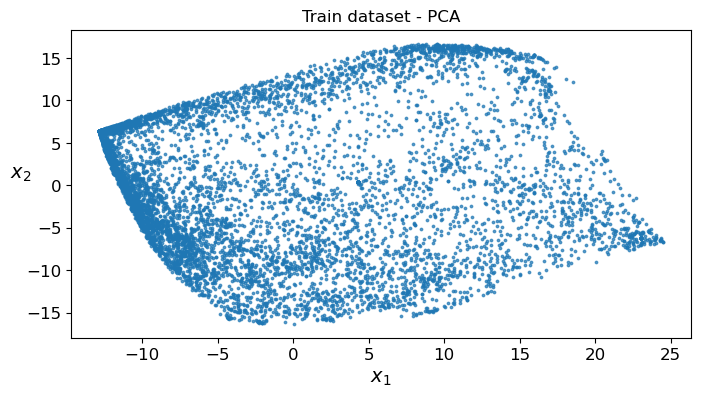

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca2 = pca.fit_transform(x_train, y_train)

plot_figure("Train dataset - PCA", X_pca2)

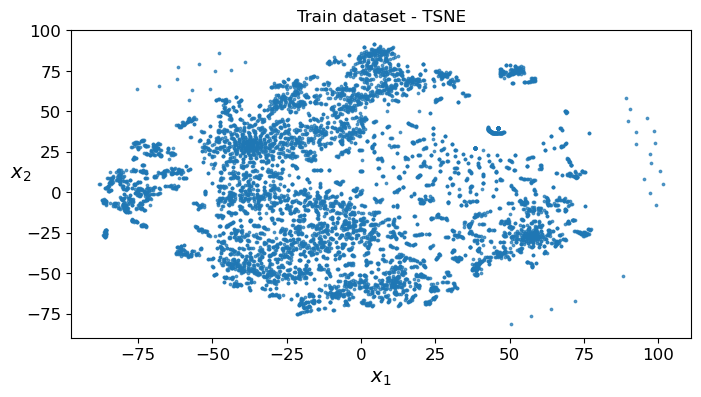

In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train)

plot_figure("Train dataset - TSNE", x_train_tsne)

Applied K-Means clusterer on the dataset and received the silhouette score. Used k = 10 at the start, i.e., 10 clusters.

In [21]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(x_train_scaled)

k = 10
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

In [22]:
tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train)

kmeans_tsne = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels_tsne = kmeans_tsne.fit_predict(x_train_tsne)

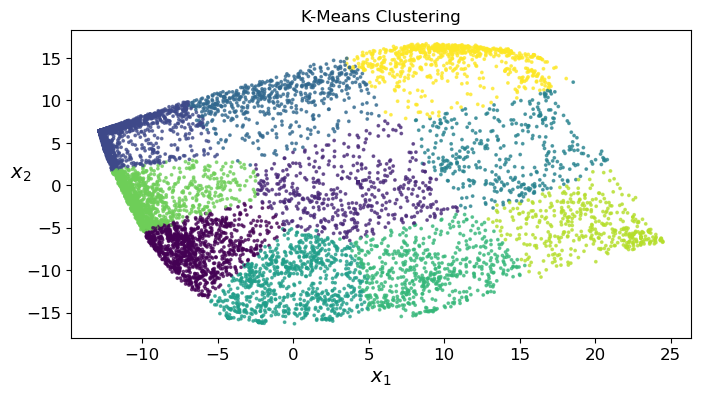

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca3 = pca.fit_transform(x_train)

plot_figure("K-Means Clustering", X_pca3, cluster_labels)

In [24]:
from sklearn.metrics import accuracy_score

def accuracy(c_labels, X, y_train, k, model):
    y_train = np.asarray(y_train)
    cl = model.fit_predict(X)

    for i in range(k):
        c = {}
        for j in range(len(c_labels)):
            if i == c_labels[j]:
                ground_truth_label = int(y_train[j])
                if ground_truth_label in c:
                    c[ground_truth_label] += 1
                else:
                    c[ground_truth_label] = 1
        max_c = max(c, key=c.get)
        for l in range(len(c_labels)):
            if i == c_labels[l]:
                cl[l] = max_c

    accuracy = accuracy_score(y_train, cl)  # Compare with ground truth labels
    print(f"Clustering Accuracy: {accuracy}")
    return accuracy

In [25]:
a1 = accuracy(cluster_labels, X_pca, y_train, k, kmeans)

Clustering Accuracy: 0.3153766769865841


C:\Users\Archisa\AppData\Local\Temp\ipykernel_38404\1095015071.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ground_truth_label = int(y_train[j])


In [26]:
a2 = accuracy(cluster_labels_tsne, x_train_tsne, y_train, k, kmeans_tsne)

Clustering Accuracy: 0.3638802889576883


C:\Users\Archisa\AppData\Local\Temp\ipykernel_38404\1095015071.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ground_truth_label = int(y_train[j])


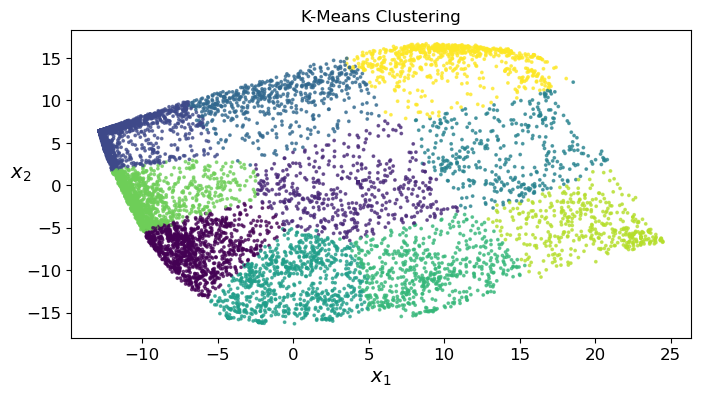

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca3 = pca.fit_transform(x_train)

plot_figure("K-Means Clustering", X_pca3, cluster_labels)

In [28]:
cluster_labels

array([1, 1, 1, ..., 3, 3, 3])

In [29]:
cluster_labels is kmeans.labels_

False

In [30]:
kmeans.inertia_

514289.79313753353

In [31]:
kmeans.cluster_centers_

array([[-1.68146373e+01, -1.64277240e+01],
       [ 1.02800814e+01,  8.63859683e-03],
       [-2.67253864e+01,  1.38789494e+01],
       [-1.95123218e+00,  2.35547048e+01],
       [ 3.46208462e+01,  8.48424552e+00],
       [-1.70483848e+00, -2.68945124e+01],
       [ 2.03650314e+01, -2.45252344e+01],
       [-2.32143602e+01, -2.40598877e+00],
       [ 4.72576418e+01, -1.26538895e+01],
       [ 2.66718043e+01,  3.35021296e+01]])

In [32]:
kmeans.labels_

array([4, 4, 4, ..., 3, 3, 3])

In [33]:
from sklearn.metrics import silhouette_score

silhouette_scores = silhouette_score(X_pca, cluster_labels)
print("Silhouette Score = ", silhouette_scores)

Silhouette Score =  0.5418970829711726


In [34]:
from sklearn.metrics import silhouette_score

silhouette_scores = silhouette_score(x_train_tsne, cluster_labels_tsne)
print("Silhouette Score = ", silhouette_scores)

Silhouette Score =  0.50966996


In [35]:
# Reference : https://colab.research.google.com/drive/1wq7JGYCT6Ctgd572KN9_QuIJwCS9tNo5?usp=sharing#scrollTo=7ZtUIKwNEcFS
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

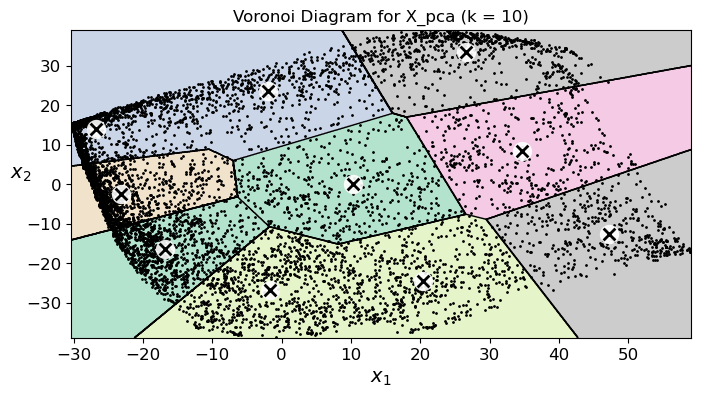

In [36]:
plt.figure(figsize=(8, 4))
plt.title("Voronoi Diagram for X_pca (k = 10)")
plot_decision_boundaries(kmeans, X_pca)
plt.show()

### 2) Hard & Soft Clustering

#### DBSCAN Clustering (Hard Clustering)

To find the best value for epsilon, we first plot the K-distance graph

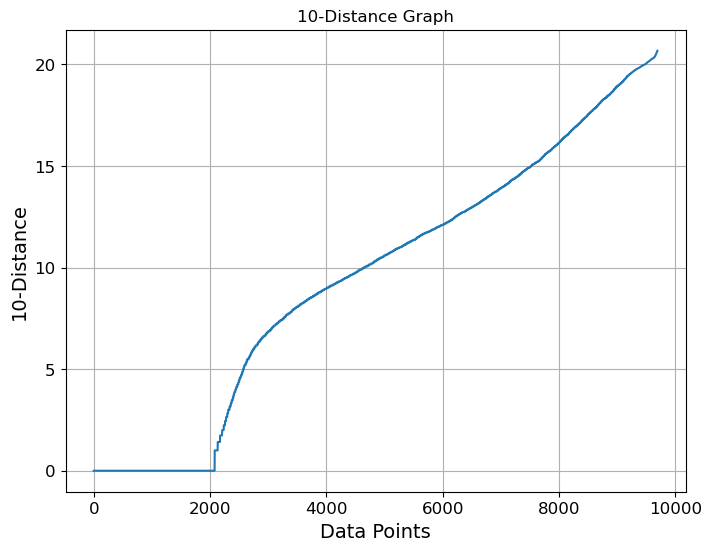

In [37]:
from sklearn.neighbors import NearestNeighbors

# Compute k-distances
k = 10 
nn = NearestNeighbors(n_neighbors=k)
nn.fit(x_train)
distances, _ = nn.kneighbors(x_train)

# Sort distances
sorted_distances = np.sort(distances[:, -1])

# Plot k-distance graph
plt.figure(figsize=(8, 6))
plt.plot(range(len(x_train)), sorted_distances)
plt.xlabel("Data Points")
plt.ylabel(f"{k}-Distance")
plt.title(f"{k}-Distance Graph")
plt.grid()
plt.show()

In [46]:
from sklearn.cluster import DBSCAN

# nos 14, 200, silhuette = 31
# nos 14.3, 210, silhuette = 32
dbscan = DBSCAN(eps=14.6, min_samples=210) 

dbscan.fit(x_train)

labels_dbscan = dbscan.labels_
print("Labels", labels_dbscan)

unique_labels, counts = np.unique(labels_dbscan, return_counts=True)

# Create a dictionary to store the counts for each label
label_counts = dict(zip(unique_labels, counts))

# Print the counts
for label, count in label_counts.items():
    if label == -1:
        print(f"Noise Points: {count} data points")
    else:
        print(f"Cluster {label}: {count} data points")

Labels [-1 -1 -1 ... -1 -1 -1]
Noise Points: 2816 data points
Cluster 0: 731 data points
Cluster 1: 3910 data points
Cluster 2: 231 data points
Cluster 3: 2002 data points


In [70]:
dbscan2 = DBSCAN(eps=8, min_samples=15)
dbscan2.fit(x_train)

labels_dbscan2 = dbscan2.labels_
print("Labels", labels_dbscan2)

unique_labels2, counts2 = np.unique(labels_dbscan2, return_counts=True)

# Create a dictionary to store the counts for each label
label_counts2 = dict(zip(unique_labels2, counts2))

# Print the counts
for label2, count2 in label_counts2.items():
    if label == -1:
        print(f"Noise Points: {count2} data points")
    else:
        print(f"Cluster {label2}: {count2} data points")

Labels [-1 -1 -1 ... -1 -1 -1]
Cluster -1: 5923 data points
Cluster 0: 1181 data points
Cluster 1: 83 data points
Cluster 2: 2002 data points
Cluster 3: 164 data points
Cluster 4: 15 data points
Cluster 5: 33 data points
Cluster 6: 47 data points
Cluster 7: 110 data points
Cluster 8: 32 data points
Cluster 9: 15 data points
Cluster 10: 37 data points
Cluster 11: 16 data points
Cluster 12: 32 data points


We tried to play around with more epsilon and min_sample values however, on using PCA and TSNE, it only produced noise clusters.
So we chose different values for them both to have clusters with labels other than -1

Cluster -1: 716 data points
Cluster 0: 8686 data points
Cluster 1: 288 data points
Silhouette Score DBSCAN + PCA =  0.22816036894267047


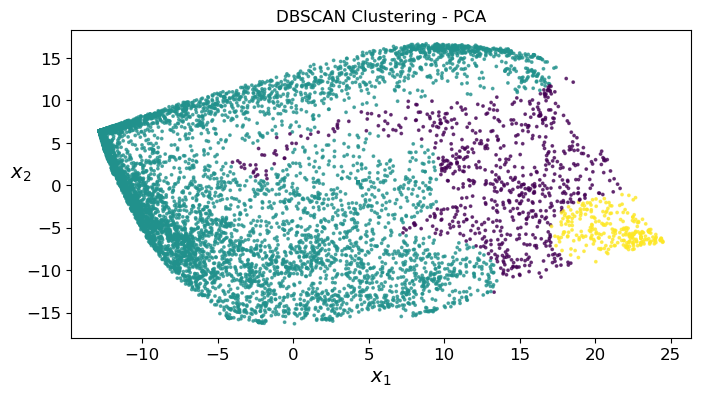

In [68]:
pca = PCA(n_components=2)
X_pca_db = pca.fit_transform(x_train)

dbscan = DBSCAN(eps=3, min_samples=180) 
labels_dbscan_pca = dbscan.fit_predict(X_pca_db)

unique_labels6, counts6 = np.unique(labels_dbscan_pca, return_counts=True)

# Create a dictionary to store the counts for each label
label_counts6 = dict(zip(unique_labels6, counts6))

# Print the counts
for label6, count6 in label_counts6.items():
    if label == -1:
        print(f"Noise Points: {count6} data points")
    else:
        print(f"Cluster {label6}: {count6} data points")

silhouette_scores_dbscan = silhouette_score(X_pca_db, labels_dbscan_pca)
print("Silhouette Score DBSCAN + PCA = ", silhouette_scores_dbscan)

plot_figure("DBSCAN Clustering - PCA", X_pca_db, labels_dbscan_pca)

In [86]:
acc_dbscan_pca = accuracy(labels_dbscan_pca, X_pca_db, y_train, 2, dbscan)
# print("Accuracy of DBSCAN with 2 clusters using PCA =", acc_dbscan_pca)

Clustering Accuracy: 0.234984520123839


C:\Users\Archisa\AppData\Local\Temp\ipykernel_38404\1095015071.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ground_truth_label = int(y_train[j])


Labels [-1 -1 -1 ... -1 -1 -1]
Cluster -1: 7780 data points
Cluster 0: 1910 data points
Silhouette Score DBSCAN + TSNE =  0.24758679


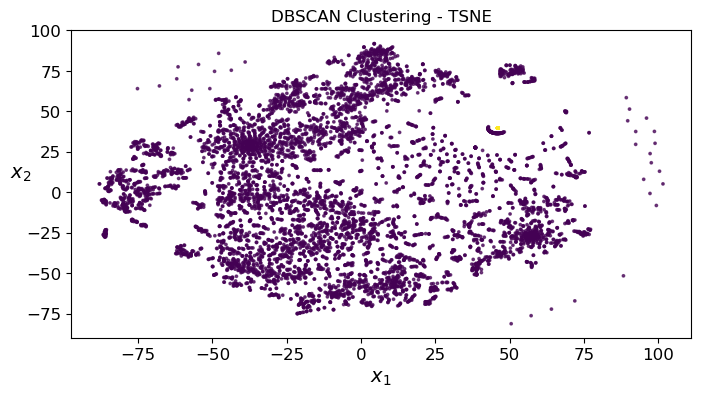

In [90]:
dbscan_tsne = TSNE(n_components=2, random_state=42)
db_tsne = dbscan_tsne.fit_transform(x_train)

dbscan = DBSCAN(eps=3.1, min_samples=100) 
labels_dbscan_tsne = dbscan.fit_predict(db_tsne)
print("Labels", labels_dbscan_tsne)

unique_labels5, counts5 = np.unique(labels_dbscan_tsne, return_counts=True)

# Create a dictionary to store the counts for each label
label_counts5 = dict(zip(unique_labels5, counts5))

# Print the counts
for label5, count5 in label_counts5.items():
    if label == -1:
        print(f"Noise Points: {count5} data points")
    else:
        print(f"Cluster {label5}: {count5} data points")

silhouette_scores_db_tsne = silhouette_score(db_tsne, labels_dbscan_tsne)
print("Silhouette Score DBSCAN + TSNE = ", silhouette_scores_db_tsne)

plot_figure("DBSCAN Clustering - TSNE", db_tsne, labels_dbscan_tsne)

In [92]:
acc_dbscan_tsne = accuracy(labels_dbscan, db_tsne, y_train, 2, dbscan)
# print("Accuracy of DBSCAN with 2 clusters using TSNE =", acc_dbscan_tsne)

Clustering Accuracy: 0.14489164086687306


C:\Users\Archisa\AppData\Local\Temp\ipykernel_38404\1095015071.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ground_truth_label = int(y_train[j])


#### Fuzzy C Means Clustering (Soft Clustering)

In [72]:
#Added this to ensure everyone can run it
!pip install fuzzy-c-means

In [81]:
def accuracy_fcm(c_labels, X, y_train, k, model):
    y_train = np.asarray(y_train)
    model.fit(X)
    cl = model.predict(X)

    for i in range(k):
        c = {}
        for j in range(len(c_labels)):
            if i == c_labels[j]:
                ground_truth_label = int(y_train[j])
                if ground_truth_label in c:
                    c[ground_truth_label] += 1
                else:
                    c[ground_truth_label] = 1
        if c == {} :
            for l in range(len(c_labels)):
                if i == c_labels[l]:
                    c_labels[l] = -1  
        else:
            max_c = max(c, key=c.get)
            for l in range(len(c_labels)):
                if i == c_labels[l]:
                    c_labels[l] = max_c

    clustering_accuracy = accuracy_score(y_train, c_labels)
    print(f"Clustering Accuracy: {clustering_accuracy}")
    return clustering_accuracy

In [73]:
from fcmeans import FCM

fcm = FCM(n_clusters=10)
fcm.fit(x_train)

fcm_centers = fcm.centers
print("Centers:", fcm_centers)

fcm_labels = fcm.predict(x_train)
print("Labels:", fcm_labels)

Centers: [[0.93135588 0.93707816 0.94398873 ... 0.96423829 0.96539543 0.96562009]
 [0.71469479 0.71608532 0.72104087 ... 0.7678705  0.76280691 0.77100656]
 [0.18946942 0.18800024 0.18695563 ... 0.61706578 0.58601434 0.57710834]
 ...
 [0.71470643 0.71609671 0.72105242 ... 0.76787932 0.76281576 0.77101561]
 [0.7147444  0.71613391 0.72109011 ... 0.76790809 0.76284464 0.77104512]
 [0.54024325 0.54031707 0.54037865 ... 0.54412944 0.54389293 0.54401574]]
Labels: [5 5 5 ... 2 2 2]


Labels: [9 9 9 ... 5 5 5]
Silhouette Score FCM + PCA =  0.5247686847653195


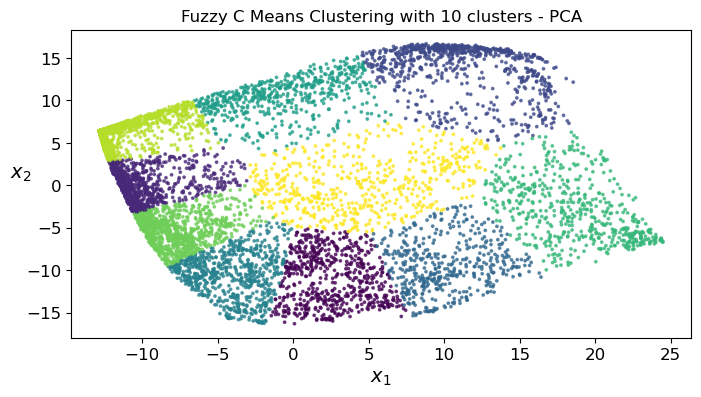

In [76]:
pca = PCA(n_components=2)
X_pca_fcm = pca.fit_transform(x_train)

fcm = FCM(n_clusters=10)
fcm.fit(X_pca_fcm)

fcm_labels_pca = fcm.predict(X_pca_fcm)
print("Labels:", fcm_labels_pca)

silhouette_scores_fcm = silhouette_score(X_pca_fcm, fcm_labels_pca)
print("Silhouette Score FCM + PCA = ", silhouette_scores_fcm)

plot_figure("Fuzzy C Means Clustering with 10 clusters - PCA", X_pca_fcm, fcm_labels_pca)

In [84]:
acc_fcm_pca = accuracy_fcm(fcm_labels_pca, X_pca_fcm, y_train, 10, fcm)

Clustering Accuracy: 0.2917440660474716


C:\Users\Archisa\AppData\Local\Temp\ipykernel_38404\684743945.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ground_truth_label = int(y_train[j])


Labels: [2 2 2 ... 1 1 1]
Silhouette Score FCM + TSNE =  0.50568557


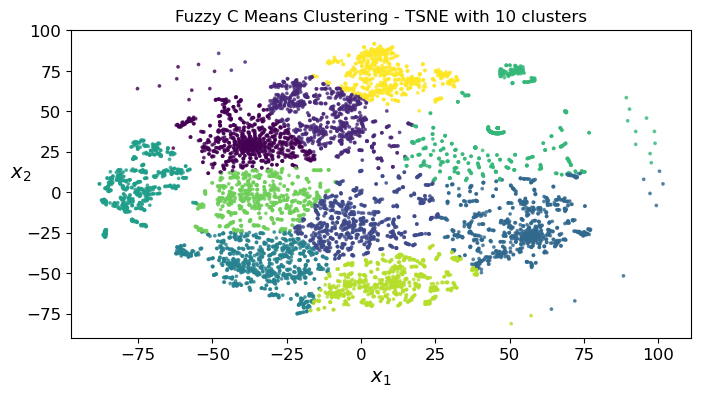

In [80]:
fcm_tsne = TSNE(n_components=2, random_state=42)
tsne_fcm = fcm_tsne.fit_transform(x_train)

fcm = FCM(n_clusters=10)
fcm.fit(tsne_fcm)

fcm_labels_tsne = fcm.predict(tsne_fcm)
print("Labels:", fcm_labels_tsne)

silhouette_scores_fcm_tsne = silhouette_score(tsne_fcm, fcm_labels_tsne)
print("Silhouette Score FCM + TSNE = ", silhouette_scores_fcm_tsne)

plot_figure("Fuzzy C Means Clustering - TSNE with 10 clusters", tsne_fcm, fcm_labels_tsne)

In [85]:
acc_fcm_tsne = accuracy_fcm(fcm_labels_tsne, tsne_fcm, y_train, 10, fcm)

Clustering Accuracy: 0.3303405572755418


C:\Users\Archisa\AppData\Local\Temp\ipykernel_38404\684743945.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ground_truth_label = int(y_train[j])


Fuzzy C Means with 2 clusters

In [104]:
fcm2 = FCM(n_clusters=2)
fcm2.fit(x_train)

fcm_centers2 = fcm2.centers
print("FCM Centres")
print(fcm_centers2)

fcm_labels2 = fcm2.predict(x_train)
print("FCM Labels")
print(fcm_labels2)

FCM Centres
[[0.52886528 0.53020832 0.53110725 ... 0.59206142 0.58812693 0.5896963 ]
 [0.80069046 0.8014842  0.80760129 ... 0.85142117 0.84739815 0.85470717]]
FCM Labels
[0 0 0 ... 0 0 0]


Labels: [6 6 6 ... 6 6 6]
Silhouette Score FCM + PCA with 2 clusters =  0.29554924292680984


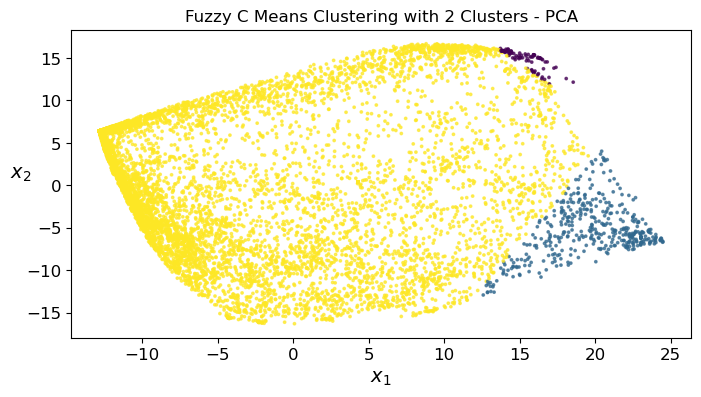

In [105]:
pca = PCA(n_components=2)
X_pca_fcm2 = pca.fit_transform(x_train)

fcm2 = FCM(n_clusters=2)
fcm2.fit(X_pca_fcm2)

fcm_labels_pca2 = fcm.predict(X_pca_fcm2)
print("Labels:", fcm_labels_pca2)

silhouette_scores_fcm2 = silhouette_score(X_pca_fcm2, fcm_labels_pca2)
print("Silhouette Score FCM + PCA with 2 clusters = ", silhouette_scores_fcm2)

plot_figure("Fuzzy C Means Clustering with 2 Clusters - PCA", X_pca_fcm2, fcm_labels_pca2)

In [106]:
acc_fcm_pca2 = accuracy_fcm(fcm_labels_pca2, X_pca_fcm2, y_train, 2, fcm)

Clustering Accuracy: 0.04871001031991744


C:\Users\Archisa\AppData\Local\Temp\ipykernel_38404\684743945.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ground_truth_label = int(y_train[j])


Labels: [0 0 0 ... 1 1 1]
Silhouette Score FCM + TSNE with 2 clusters =  0.21512191


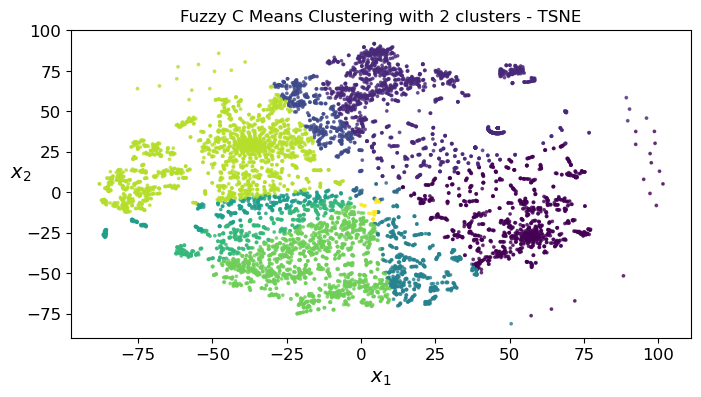

In [107]:
fcm_tsne = TSNE(n_components=2, random_state=42)
tsne_fcm2 = fcm_tsne.fit_transform(x_train)

fcm2 = FCM(n_clusters=2)
fcm2.fit(tsne_fcm2)

fcm_labels_tsne2 = fcm.predict(tsne_fcm2)
print("Labels:", fcm_labels_tsne2)

silhouette_scores_fcm_tsne2 = silhouette_score(tsne_fcm2, fcm_labels_tsne2)
print("Silhouette Score FCM + TSNE with 2 clusters = ", silhouette_scores_fcm_tsne2)

plot_figure("Fuzzy C Means Clustering with 2 clusters - TSNE", tsne_fcm2, fcm_labels_tsne2)

In [108]:
acc_fcm_tsne2 = accuracy_fcm(fcm_labels_tsne2, tsne_fcm2, y_train, 2, fcm)

Clustering Accuracy: 0.15067079463364294


C:\Users\Archisa\AppData\Local\Temp\ipykernel_38404\684743945.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ground_truth_label = int(y_train[j])


### 3) Determining Optimal Number of Clusters

In [98]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

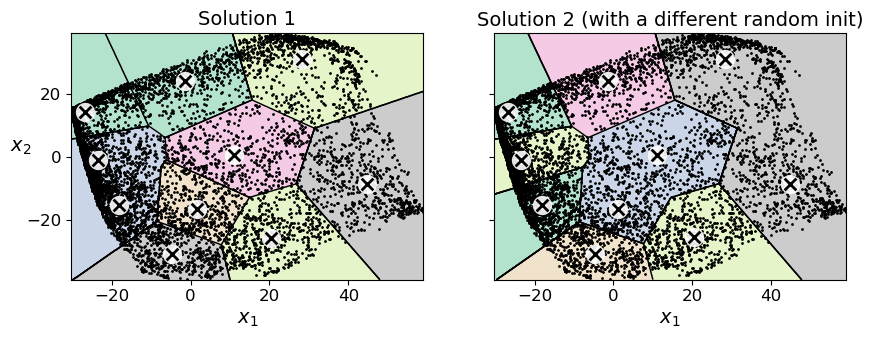

In [99]:
kmeans_rnd_init1 = KMeans(n_clusters=10, init="random", n_init=1,
                         algorithm="lloyd", random_state=44)
kmeans_rnd_init2 = KMeans(n_clusters=10, init="random", n_init=1,
                         algorithm="lloyd", random_state=50)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X_pca,
                          "Solution 1", "Solution 2 (with a different random init)")
plt.show()

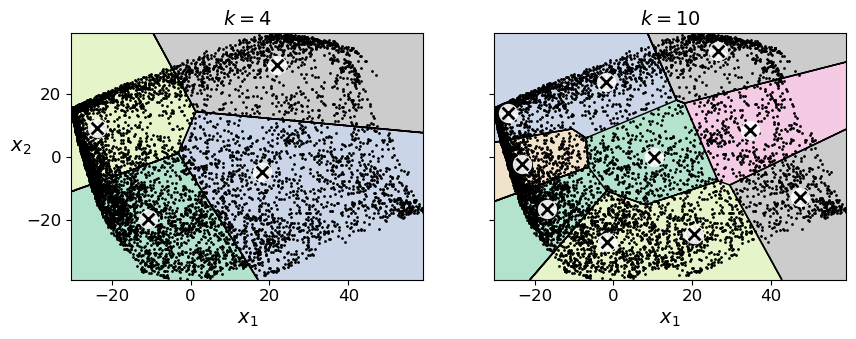

In [100]:
kmeans_k4 = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_k10 = KMeans(n_clusters=10, random_state=42, n_init=10)

plot_clusterer_comparison(kmeans_k4, kmeans_k10, X_pca, "$k=4$", "$k=10$")
plt.show()

In [101]:
max_cluster=13
kmeans_per_k = [KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_pca)
                for k in range(1, max_cluster)]
inertias = [model.inertia_ for model in kmeans_per_k]

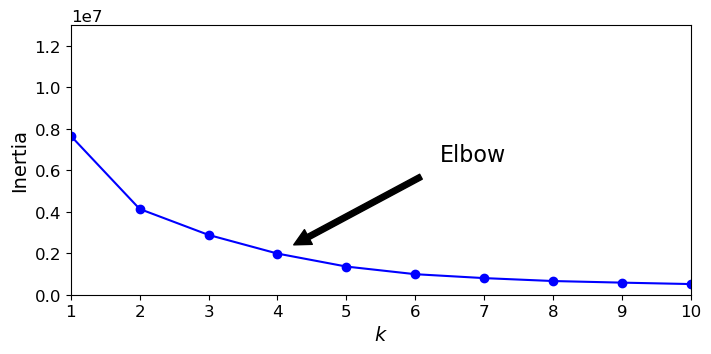

In [102]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, max_cluster), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 10, 0, 13000000])  # Adjust the y-axis limit as needed
plt.show()


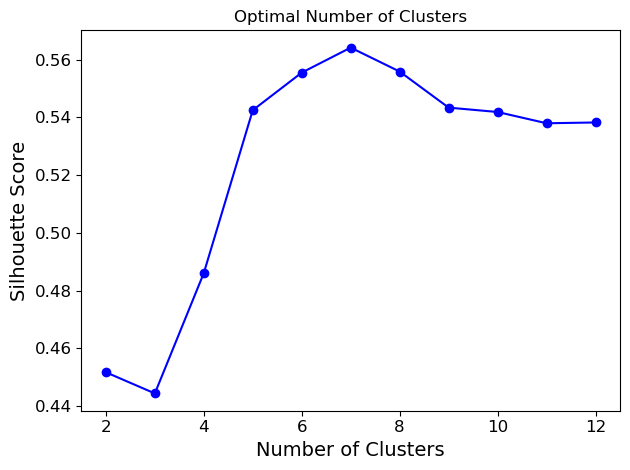

In [103]:
silhouette_scores = [silhouette_score(X_pca, model.labels_) for model in kmeans_per_k[1:]]     

plt.plot(range(2, max_cluster), silhouette_scores, "bo-")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Optimal Number of Clusters")
plt.tight_layout()
plt.show()